### Data Loading and Cleaning* Loads the pre-merged dataset (`cleaned_merged_dataset.csv`).
*  Convereds `northern_italy_mwh` and `slovenia_mwh` to numeric (handling mixed types
*  fileds NaN values with 0, and converts `start_date` to `datetime64[ns]` for time-series analysis.

In [9]:
import pandas as pd
data = pd.read_csv(r"C:\Users\HP\Documents\PowercastLunar\cleaned_merged_dataset.csv", low_memory=False)

In [ ]:
# Clean potential formatting issues
data['northern_italy_mwh'] = data['northern_italy_mwh'].str.replace(',', '').replace('N/A', pd.NA)
data['slovenia_mwh'] = data['slovenia_mwh'].str.replace(',', '').replace('N/A', pd.NA)

# Convert to numeric, coercing errors to NaN
data['northern_italy_mwh'] = pd.to_numeric(data['northern_italy_mwh'], errors='coerce')
data['slovenia_mwh'] = pd.to_numeric(data['slovenia_mwh'], errors='coerce')

# Check for any conversion issues
print("NaN count in northern_italy_mwh:", data['northern_italy_mwh'].isna().sum())
print("NaN count in slovenia_mwh:", data['slovenia_mwh'].isna().sum())

# Handle missing values (0 is a reasonable default for now)
data['northern_italy_mwh'] = data['northern_italy_mwh'].fillna(0)
data['slovenia_mwh'] = data['slovenia_mwh'].fillna(0)

# Confirm the data is numeric
print("northern_italy_mwh dtype:", data['northern_italy_mwh'].dtype)
print("slovenia_mwh dtype:", data['slovenia_mwh'].dtype)

### Feature Engineering
* Defineds features by excluding non-predictive columns (e.g., `start_date`, `end_date`)
* Createds a target variable `target_next_hour` by shifting `germanyluxembourg_mwh` forward by 1 hour.
* Converteds all object-type features to numeric and forward-fills remaining NaNs.

### Model Training and Evaluation* 
Splis data into 80% training and 20% testing sets (chronological split).
*  Trains an XGBoost regressor with 100 estimators, 0.1 learning rate, and max depth of 5.
*  Evaluates performance using RMSE, MAE, and directional accuracy.
*  Visualizes top 10 feature importances.

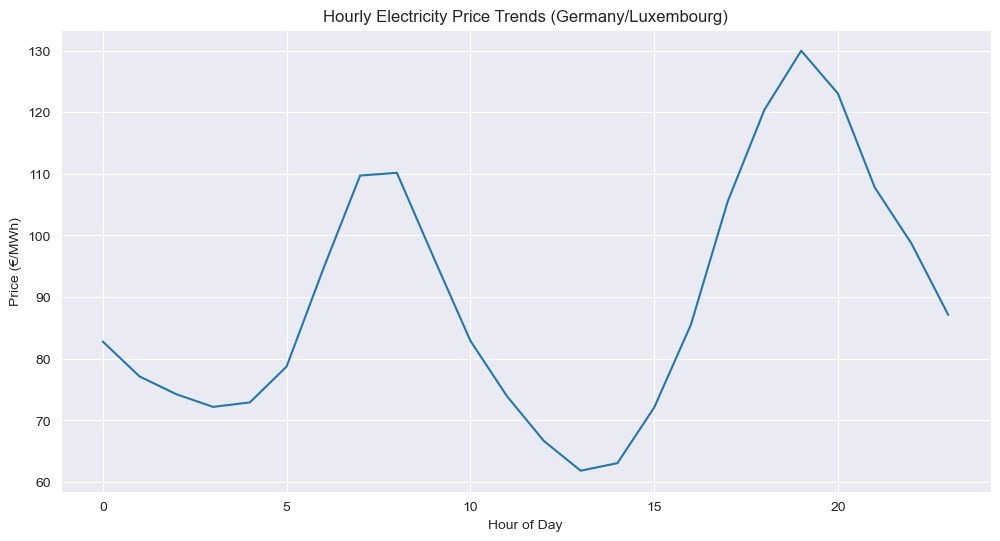

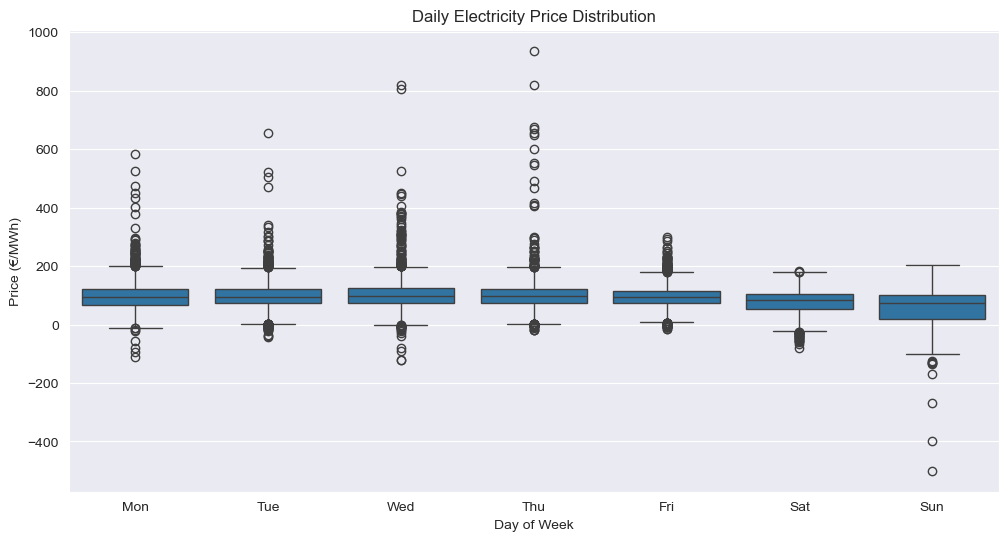

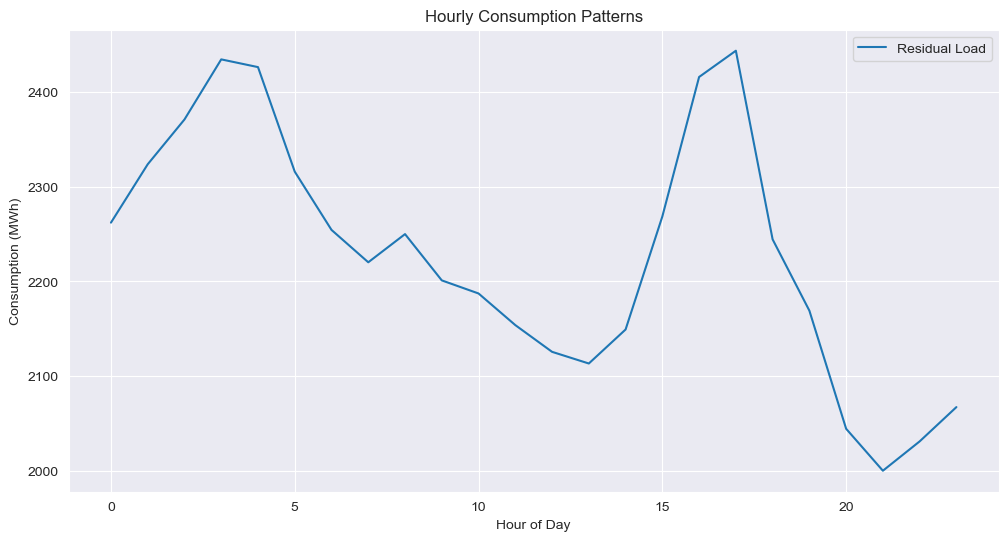

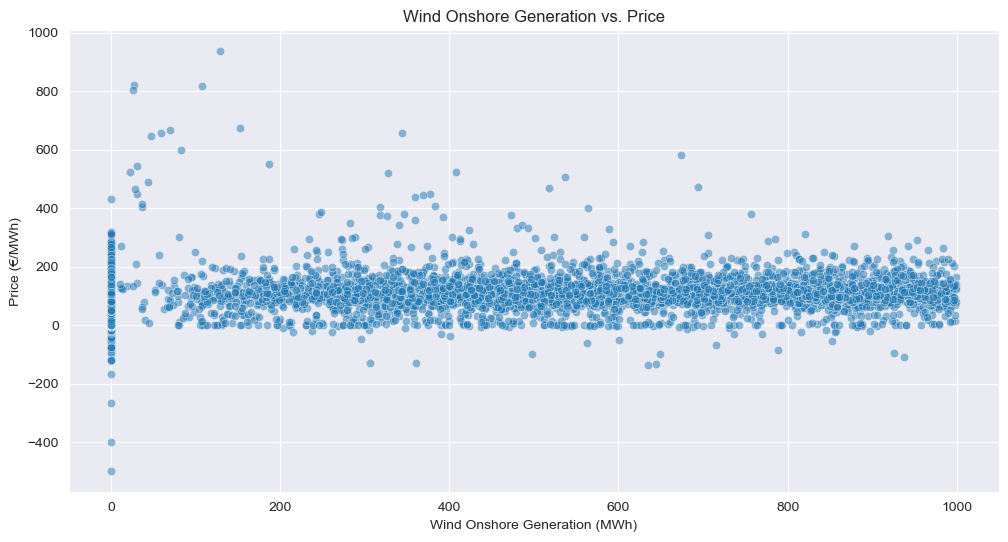

In [69]:
# Extract time components
data['hour'] = data['start_date'].dt.hour
data['day'] = data['start_date'].dt.dayofweek  
data['week'] = data['start_date'].dt.isocalendar().week

# Hourly Price Trends (Germany/Luxembourg as target)
plt.figure(figsize=(12, 6))
sns.lineplot(x='hour', y='germanyluxembourg_mwh', data=data, errorbar=None)
plt.title('Hourly Electricity Price Trends (Germany/Luxembourg)')
plt.xlabel('Hour of Day')
plt.ylabel('Price (€/MWh)')
plt.show()

# Daily Price Trends
plt.figure(figsize=(12, 6))
sns.boxplot(x='day', y='germanyluxembourg_mwh', data=data)
plt.title('Daily Electricity Price Distribution')
plt.xlabel('Day of Week')
plt.ylabel('Price (€/MWh)')
plt.xticks(ticks=range(7), labels=['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun'])
plt.show()

# Consumption Patterns
plt.figure(figsize=(12, 6))
sns.lineplot(x='hour', y='residual_load_mwh', data=data, errorbar=None, label='Residual Load')
plt.title('Hourly Consumption Patterns')
plt.xlabel('Hour of Day')
plt.ylabel('Consumption (MWh)')
plt.show()

# Generation vs. Price
plt.figure(figsize=(12, 6))
sns.scatterplot(x='wind_onshore_mwh', y='germanyluxembourg_mwh', data=data, alpha=0.5)
plt.title('Wind Onshore Generation vs. Price')
plt.xlabel('Wind Onshore Generation (MWh)')
plt.ylabel('Price (€/MWh)')
plt.show()

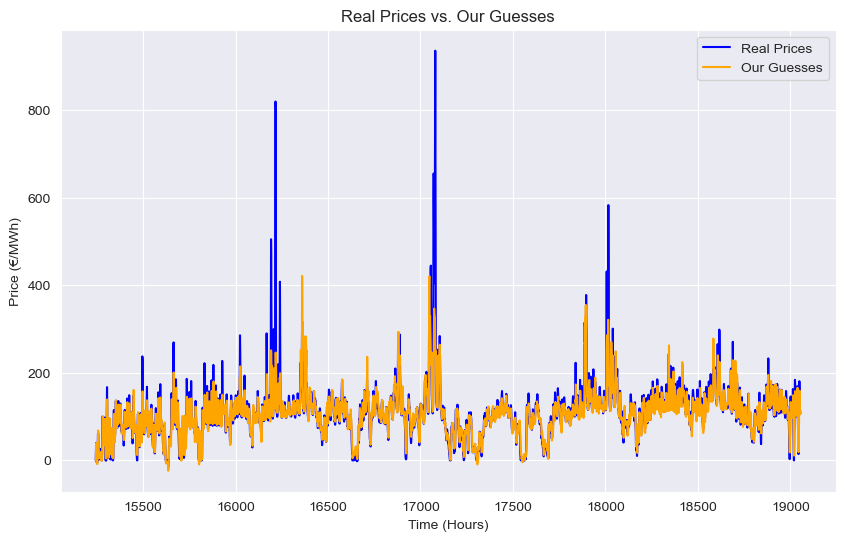

In [144]:
import matplotlib.pyplot as plt

# Plot the actual and predicted prices as a line plot
plt.figure(figsize=(10, 6))  
plt.plot(y_test.index, y_test, label="Real Prices", color="blue") 
plt.plot(y_test.index, y_pred, label="Our Guesses", color="orange")  
plt.xlabel("Time (Hours)")  
plt.ylabel("Price (€/MWh)")  
plt.title("Real Prices vs. Our Guesses")  
plt.legend()  
plt.grid(True)  
plt.show()

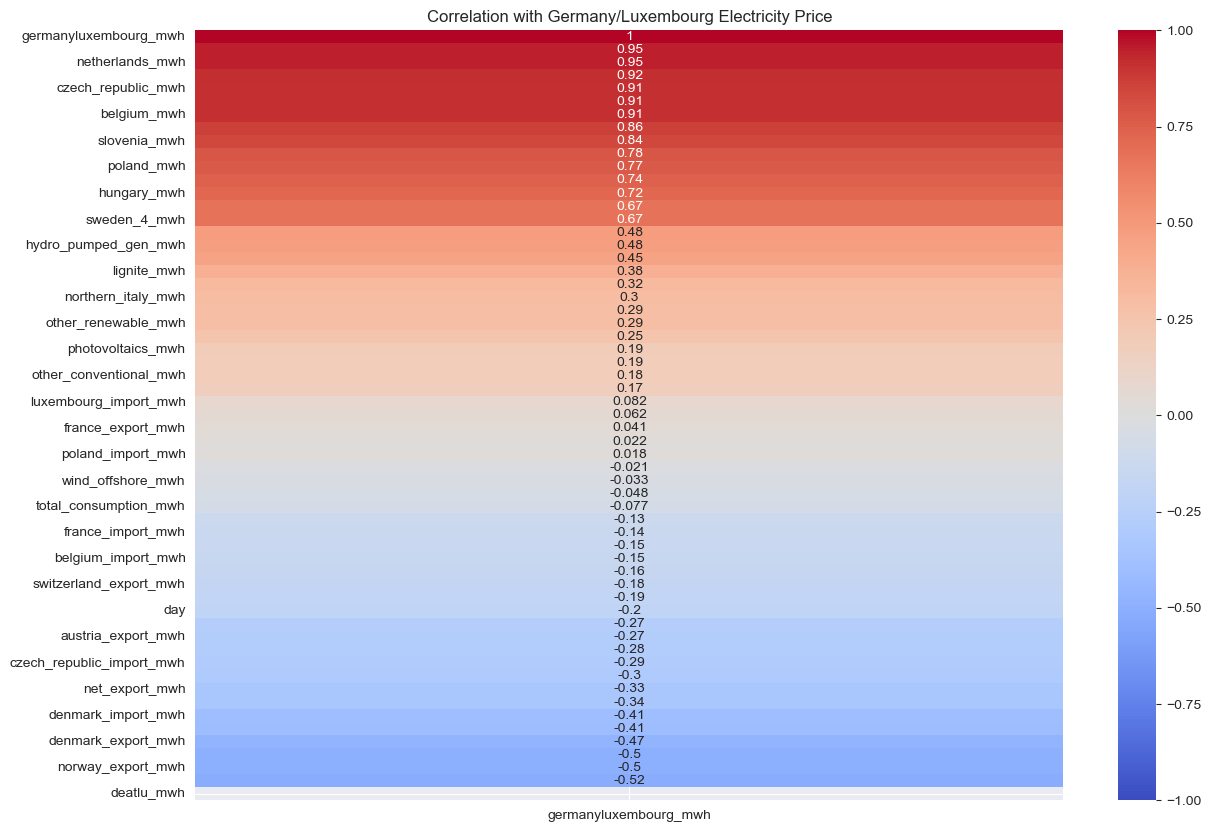

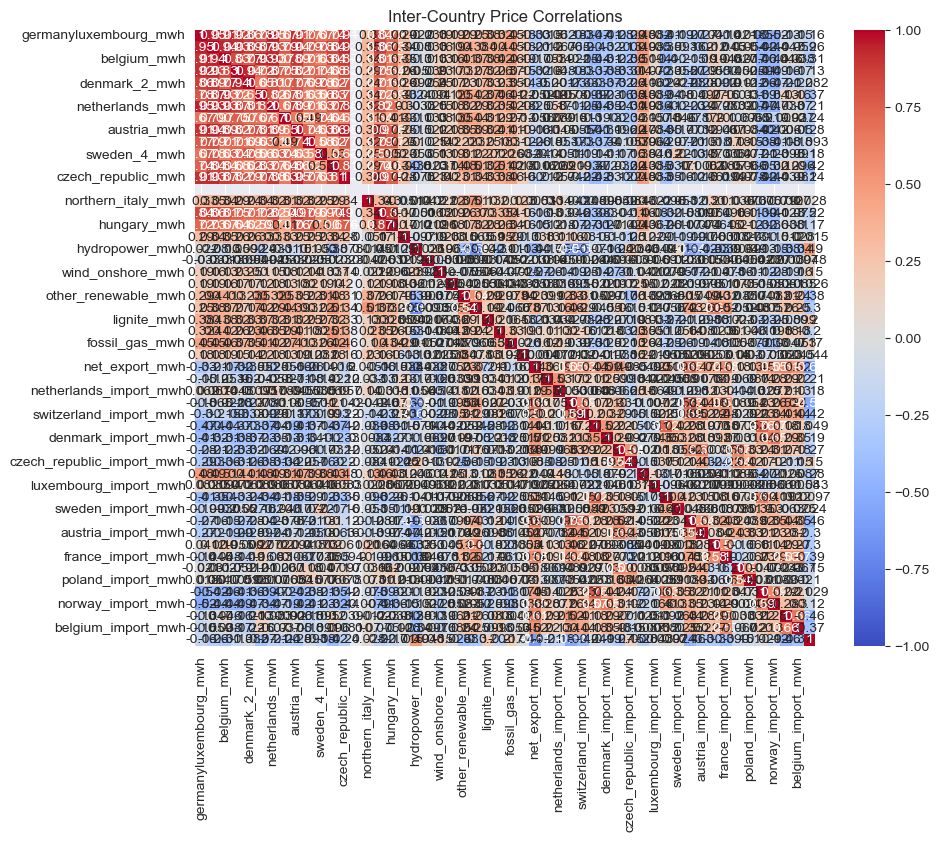

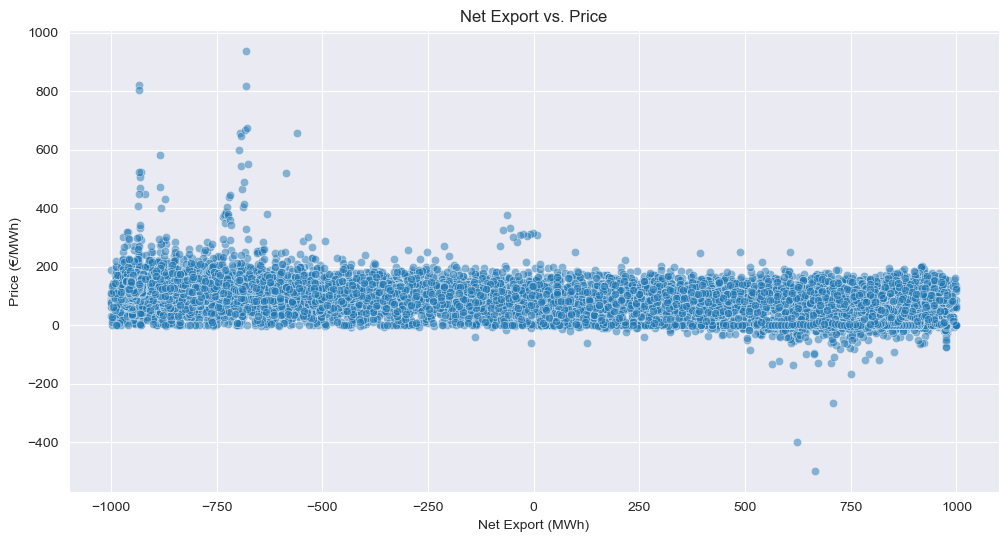

In [89]:
import numpy as np

# Select numeric columns for correlation
numeric_cols = data.select_dtypes(include=[np.number]).columns
corr_matrix = data[numeric_cols].corr()

# Heatmap of correlations with Germany/Luxembourg price
plt.figure(figsize=(14, 10))
sns.heatmap(corr_matrix[['germanyluxembourg_mwh']].sort_values(by='germanyluxembourg_mwh', ascending=False), 
            annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title('Correlation with Germany/Luxembourg Electricity Price')
plt.show()

# Inter-country price correlations
price_cols = [col for col in data.columns if '_mwh' in col and 'germanyluxembourg' not in col and 'gen' not in col and 'cons' not in col]
price_corr = data[['germanyluxembourg_mwh'] + price_cols].corr()
plt.figure(figsize=(10, 8))
sns.heatmap(price_corr, annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title('Inter-Country Price Correlations')
plt.show()

# Scatter plot of key feature (e.g., net_export_mwh)
plt.figure(figsize=(12, 6))
sns.scatterplot(x='net_export_mwh', y='germanyluxembourg_mwh', data=data, alpha=0.5)
plt.title('Net Export vs. Price')
plt.xlabel('Net Export (MWh)')
plt.ylabel('Price (€/MWh)')
plt.show()

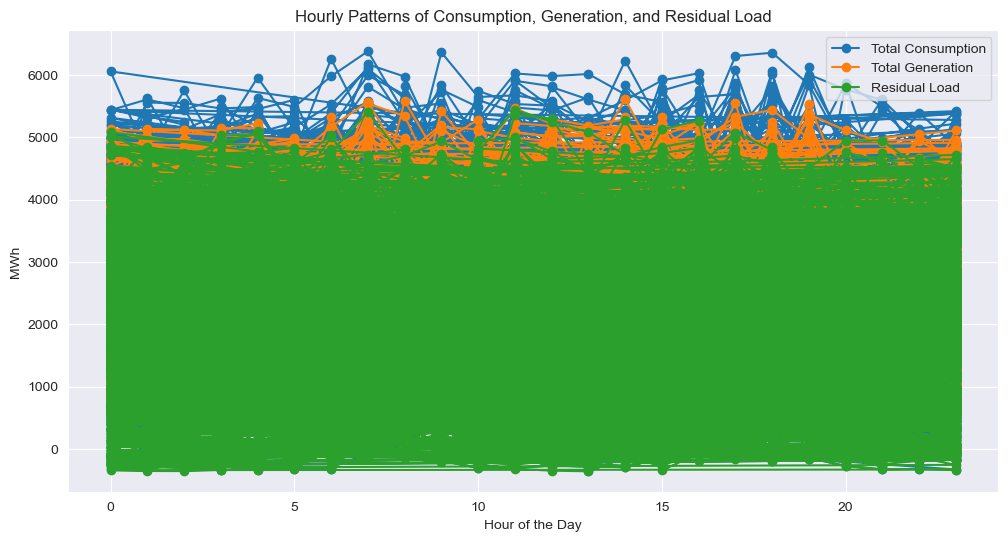

In [93]:
import matplotlib.pyplot as plt

# Set the figure size
plt.figure(figsize=(12, 6))

# Plot each variable
plt.plot(data['hour'], data['total_consumption_mwh'], label='Total Consumption', marker='o')
plt.plot(data['hour'], data['total_generation_mwh'], label='Total Generation', marker='o')
plt.plot(data['hour'], data['residual_load_mwh'], label='Residual Load', marker='o')

# Add labels and title
plt.xlabel('Hour of the Day')
plt.ylabel('MWh')
plt.title('Hourly Patterns of Consumption, Generation, and Residual Load')

# Add a legend to differentiate the lines
plt.legend()

# Show the plot
plt.show()

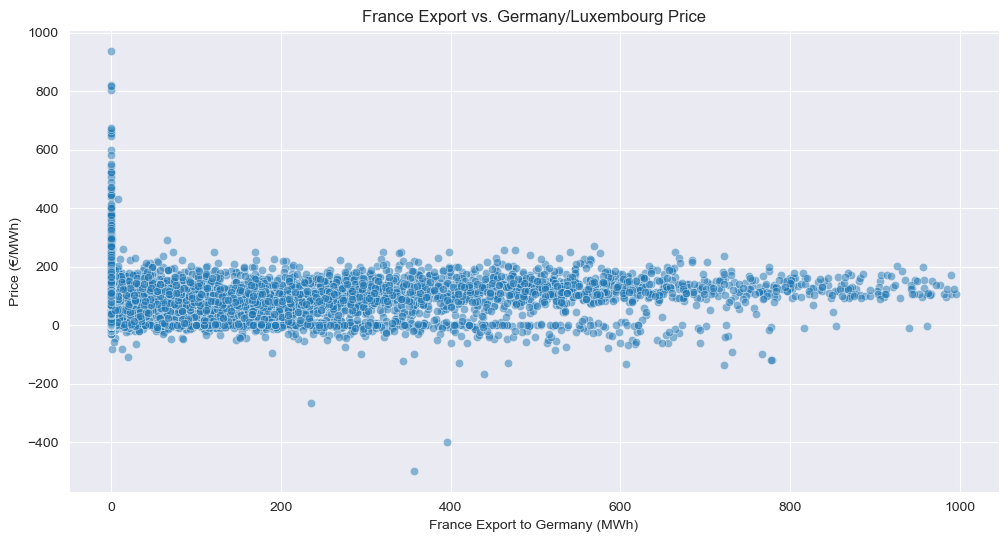

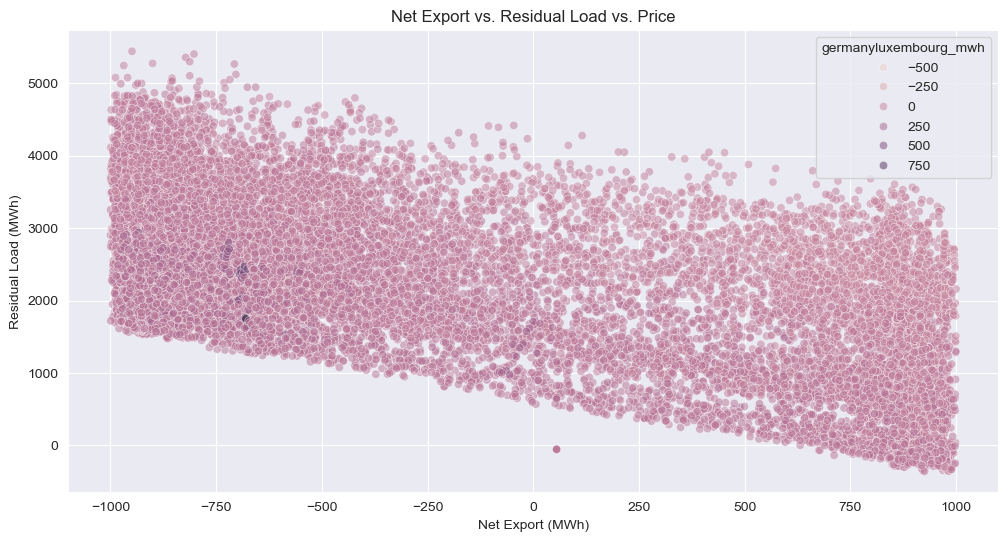

In [97]:
# Cross-border flow impact
plt.figure(figsize=(12, 6))
sns.scatterplot(x='france_export_mwh', y='germanyluxembourg_mwh', data=data, alpha=0.5)
plt.title('France Export vs. Germany/Luxembourg Price')
plt.xlabel('France Export to Germany (MWh)')
plt.ylabel('Price (€/MWh)')
plt.show()

# Net export vs. consumption
plt.figure(figsize=(12, 6))
sns.scatterplot(x='net_export_mwh', y='residual_load_mwh', hue='germanyluxembourg_mwh', data=data, alpha=0.5)
plt.title('Net Export vs. Residual Load vs. Price')
plt.xlabel('Net Export (MWh)')
plt.ylabel('Residual Load (MWh)')
plt.show()

In [113]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer


data = pd.read_csv(r"C:\Users\HP\Documents\PowercastLunar\cleaned_merged_dataset.csv")  
print("Loaded data shape:", data.shape)
print("First few rows:\n", data.head())
print("Columns:", data.columns.tolist())

# If empty, stop and fix loading
if data.empty:
    raise ValueError("DataFrame is empty. Check the data source or loading process.")

# Select numeric features
numeric_features = data.select_dtypes(include=[np.number]).columns.tolist()
features = [col for col in numeric_features if col not in ['hour', 'day', 'week']]

# Impute NaNs in features
data[features] = data[features].ffill()

# Handle NaNs in target before shifting
target = 'germanyluxembourg_mwh'
data = data.dropna(subset=[target])
print("After dropping NaNs in germanyluxembourg_mwh:", data.shape)

# Create target for next hour
data['target_next_hour'] = data[target].shift(-1)

# Drop the last row where target_next_hour is NaN
data = data.dropna(subset=['target_next_hour'])
print("After dropping NaNs in target_next_hour:", data.shape)

# Define X and y
X = data[features]
y = data['target_next_hour']

# Split data (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

# Proceed with model training
from xgboost import XGBRegressor
model = XGBRegressor(n_estimators=100, learning_rate=0.1, max_depth=5)
model.fit(X_train, y_train)

print("Model trained successfully!")

C:\Users\HP\AppData\Local\Temp\ipykernel_3712\4010138025.py:7: DtypeWarning: Columns (15,16) have mixed types. Specify dtype option on import or set low_memory=False.
  data = pd.read_csv(r"C:\Users\HP\Documents\PowercastLunar\cleaned_merged_dataset.csv")


Loaded data shape: (19056, 54)
First few rows:
             start_date  germanyluxembourg_mwh  delu_neighbours_mwh  \
0  2023-01-01 00:00:00                  -5.17                13.85   
1  2023-01-01 01:00:00                  -1.07                 9.79   
2  2023-01-01 02:00:00                  -1.47                 8.91   
3  2023-01-01 03:00:00                  -5.08                 6.58   
4  2023-01-01 04:00:00                  -4.49                 5.42   

   belgium_mwh  denmark_1_mwh  denmark_2_mwh  france_mwh  netherlands_mwh  \
0        -4.39           2.01           2.01        0.00            -3.61   
1        -1.75           1.38           1.38       -0.10            -1.46   
2        -1.46           0.09           0.09       -1.33            -1.52   
3        -5.27           0.08           0.08       -4.08            -5.00   
4        -4.41           0.05           0.05       -4.16            -4.60   

   norway_2_mwh  austria_mwh  ...  austria_export_mwh  austria_impor

Converting deatlu_mwh to numeric
RMSE: 33.43
MAE: 13.85
Directional Accuracy: 71.86%


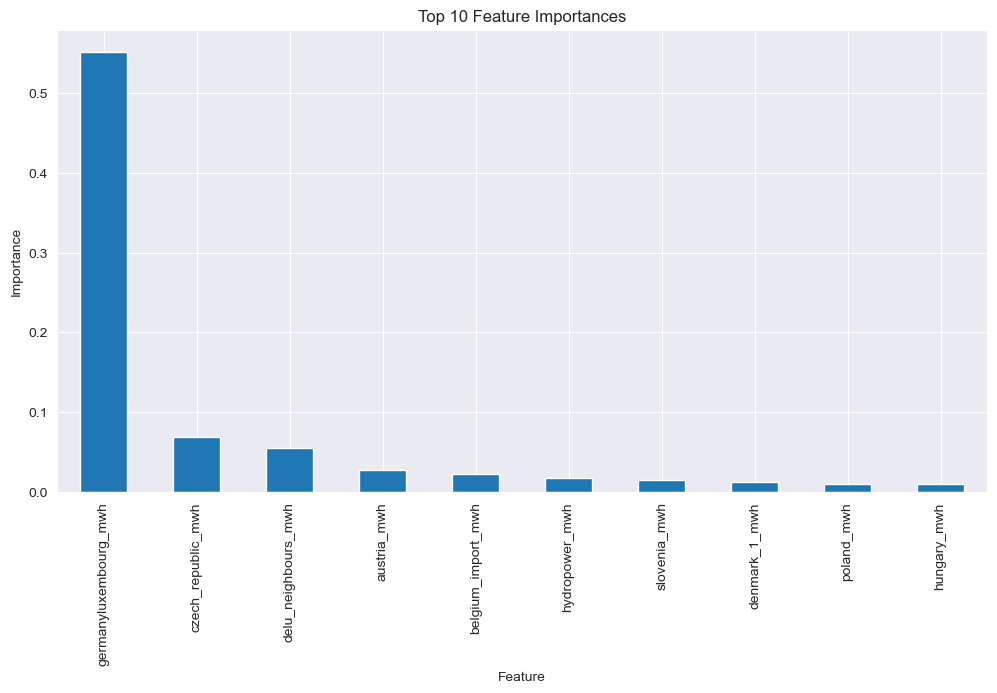

In [148]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error
import matplotlib.pyplot as plt
from xgboost import XGBRegressor

# Load data
data = pd.read_csv(r"C:\Users\HP\Documents\PowercastLunar\cleaned_merged_dataset.csv", low_memory=False)

# Convert mixed-type columns to numeric
data['northern_italy_mwh'] = pd.to_numeric(data['northern_italy_mwh'], errors='coerce')
data['slovenia_mwh'] = pd.to_numeric(data['slovenia_mwh'], errors='coerce')

# Convert start_date to datetime
data['start_date'] = pd.to_datetime(data['start_date'])

# Prepare features and target
features = [col for col in data.columns if col not in ['start_date', 'end_date', 'hour', 'day', 'week', 'target_next_hour']]
target = 'germanyluxembourg_mwh'

# Convert all object columns in features to numeric
for col in features:
    if data[col].dtype == 'object':
        print(f"Converting {col} to numeric")
        data[col] = pd.to_numeric(data[col], errors='coerce')

# Impute NaNs in features
data[features] = data[features].ffill()

# Handle NaNs in target before shifting
data = data.dropna(subset=[target])

# Shift target for 1-hour ahead prediction
data['target_next_hour'] = data[target].shift(-1)

# Drop rows with NaN in target_next_hour (last row)
data = data.dropna(subset=['target_next_hour'])

# Define X and y
X = data[features]
y = data['target_next_hour']

# Split data (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

# Train XGBoost model
model = XGBRegressor(n_estimators=100, learning_rate=0.1, max_depth=5)
model.fit(X_train, y_train)

# Predictions
y_pred = model.predict(X_test)

# Metrics
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
mae = mean_absolute_error(y_test, y_pred)
print(f"RMSE: {rmse:.2f}")
print(f"MAE: {mae:.2f}")

# Directional Accuracy
y_test_series = pd.Series(y_test.values, index=y_test.index)
y_pred_series = pd.Series(y_pred, index=y_test.index)
actual_diff = y_test_series.diff().dropna()
pred_diff = y_pred_series.diff().dropna()
common_index = actual_diff.index.intersection(pred_diff.index)
directional = np.sign(actual_diff.loc[common_index]) == np.sign(pred_diff.loc[common_index])
directional_accuracy = directional.mean() * 100
print(f"Directional Accuracy: {directional_accuracy:.2f}%")

# Feature Importance
importances = pd.Series(model.feature_importances_, index=features).sort_values(ascending=False)
plt.figure(figsize=(12, 6))
importances[:10].plot(kind='bar')
plt.title('Top 10 Feature Importances')
plt.xlabel('Feature')
plt.ylabel('Importance')
plt.show()


In [127]:
import joblib
joblib.dump(model, 'PowerCast_price_predictor.pkl')

['PowerCast_price_predictor.pkl']